<a href="https://colab.research.google.com/github/Safayat777/my_new/blob/main/Snn_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install snntorch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 4.5 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

import snntorch as snn
from snntorch import spikegen
from snntorch import functional as SF

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [3]:
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [4]:
train_data = ImageFolder('/content/drive/MyDrive/DataSet/ArsenicSkinImageBD', transform=transform)
test_data  = ImageFolder('/content/drive/MyDrive/DataSet/Original', transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=32, shuffle=False)

classes = train_data.classes
print("Classes:", classes)

Classes: ['infected', 'not_infected']


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_steps = 50     # ↑ time steps = ↑ accuracy
beta = 0.9
epochs = 25
lr = 0.0005

In [6]:
class ImprovedSNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2)
        self.lif1 = snn.Leaky(beta=beta)

        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2)
        self.lif2 = snn.Leaky(beta=beta)

        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2)
        self.lif3 = snn.Leaky(beta=beta)

        self.fc1 = nn.Linear(64 * 4 * 4, 2)
        self.lif4 = snn.Leaky(beta=beta)

    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        mem4 = self.lif4.init_leaky()

        spk_out = []

        for t in range(num_steps):
            cur1 = self.pool1(self.conv1(x[t]))
            spk1, mem1 = self.lif1(cur1, mem1)

            cur2 = self.pool2(self.conv2(spk1))
            spk2, mem2 = self.lif2(cur2, mem2)

            cur3 = self.pool3(self.conv3(spk2))
            spk3, mem3 = self.lif3(cur3, mem3)

            cur4 = self.fc1(spk3.view(spk3.size(0), -1))
            spk4, mem4 = self.lif4(cur4, mem4)

            spk_out.append(spk4)

        return torch.stack(spk_out)

In [7]:
model = ImprovedSNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = SF.ce_rate_loss()

In [8]:
train_acc, test_acc = [], []
train_loss, test_loss = [], []

In [9]:
for epoch in range(epochs):

    # ========== TRAINING ==========
    model.train()
    correct, total = 0, 0
    running_loss = 0

    for data, targets in train_loader:
        data, targets = data.to(device), targets.to(device)

        data = spikegen.rate(data, num_steps=num_steps)

        optimizer.zero_grad()
        spk_out = model(data)

        loss = loss_fn(spk_out, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        pred = spk_out.sum(dim=0).argmax(dim=1)
        correct += (pred == targets).sum().item()
        total += targets.size(0)

    train_accuracy = 100 * correct / total
    avg_train_loss = running_loss / len(train_loader)

    train_acc.append(train_accuracy)
    train_loss.append(avg_train_loss)

    # ========== TESTING ==========
    model.eval()
    correct, total = 0, 0
    running_loss = 0

    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)

            data = spikegen.rate(data, num_steps=num_steps)

            spk_out = model(data)
            loss = loss_fn(spk_out, targets)

            running_loss += loss.item()

            pred = spk_out.sum(dim=0).argmax(dim=1)
            correct += (pred == targets).sum().item()
            total += targets.size(0)

    test_accuracy = 100 * correct / total
    avg_test_loss = running_loss / len(test_loader)

    test_acc.append(test_accuracy)
    test_loss.append(avg_test_loss)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Acc: {train_accuracy:.2f}% | "
          f"Test Acc: {test_accuracy:.2f}% | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Test Loss: {avg_test_loss:.4f}")

Epoch 1/25 | Train Acc: 55.96% | Test Acc: 68.69% | Train Loss: 0.6960 | Test Loss: 0.6509
Epoch 2/25 | Train Acc: 61.97% | Test Acc: 69.77% | Train Loss: 0.6661 | Test Loss: 0.6190
Epoch 3/25 | Train Acc: 63.23% | Test Acc: 72.96% | Train Loss: 0.6494 | Test Loss: 0.5918
Epoch 4/25 | Train Acc: 63.45% | Test Acc: 72.96% | Train Loss: 0.6394 | Test Loss: 0.5807
Epoch 5/25 | Train Acc: 64.17% | Test Acc: 70.16% | Train Loss: 0.6337 | Test Loss: 0.6174
Epoch 6/25 | Train Acc: 64.56% | Test Acc: 74.20% | Train Loss: 0.6325 | Test Loss: 0.5745
Epoch 7/25 | Train Acc: 64.75% | Test Acc: 74.28% | Train Loss: 0.6258 | Test Loss: 0.5775
Epoch 8/25 | Train Acc: 64.98% | Test Acc: 74.13% | Train Loss: 0.6230 | Test Loss: 0.5743
Epoch 9/25 | Train Acc: 65.76% | Test Acc: 75.21% | Train Loss: 0.6184 | Test Loss: 0.5606
Epoch 10/25 | Train Acc: 66.00% | Test Acc: 73.74% | Train Loss: 0.6157 | Test Loss: 0.5807
Epoch 11/25 | Train Acc: 66.37% | Test Acc: 73.66% | Train Loss: 0.6122 | Test Loss: 0.57

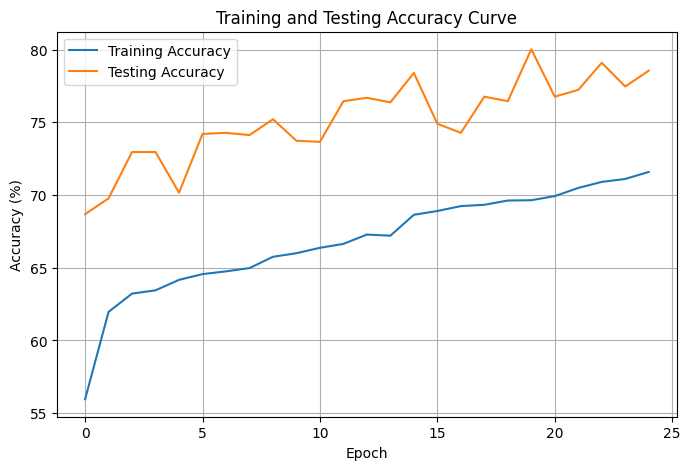

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(test_acc, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Testing Accuracy Curve')
plt.legend()
plt.grid(True)
plt.show()


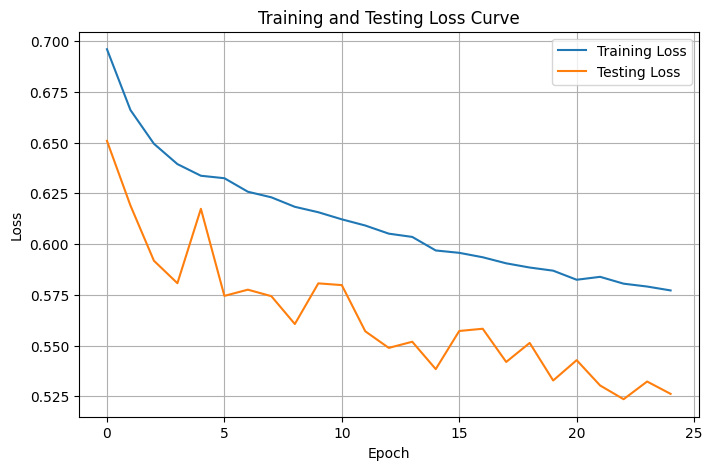

In [11]:
plt.figure(figsize=(8,5))
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Curve')
plt.legend()
plt.grid(True)
plt.show()


In [12]:
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for data, targets in test_loader:
        data, targets = data.to(device), targets.to(device)
        data = spikegen.rate(data, num_steps=num_steps)

        spk_out = model(data)
        pred = spk_out.sum(dim=0).argmax(dim=1)

        correct += (pred == targets).sum().item()
        total += targets.size(0)

test_acc = 100 * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")

Test Accuracy: 80.03%


In [16]:

from google.colab import files
uploaded = files.upload()

Saving non_infected.png to non_infected.png


In [17]:
def predict_image(path):
    img = Image.open(path).convert('L')
    img = transform(img).unsqueeze(0).to(device)

    img = spikegen.rate(img, num_steps=num_steps)

    with torch.no_grad():
        spk_out = model(img)
        pred = spk_out.sum(dim=0).argmax(dim=1)

    return classes[pred.item()]

In [18]:
for file in uploaded.keys():
    print("Prediction:", predict_image(file))

Prediction: not_infected
